# Open-Source Energy System Modeling - Homework no. 3 
# Westeros Tutorial baseline scenario extension - including emission taxes and gas power plants

### *Integrated Assessment Modeling for the 21st Century*

For information on how to install *MESSAGEix*, please refer to [Installation page](https://message.iiasa.ac.at/en/stable/getting_started.html) and for getting *MESSAGEix* tutorials, please follow the steps mentioned in [Tutorials](https://message.iiasa.ac.at/en/stable/tutorials.html).

Please refer to the [user guidelines](https://github.com/iiasa/message_ix/blob/master/NOTICE.rst)
for additional information on using *MESSAGEix*, including the recommended citation and how to name new models.

**Pre-requisites**
- Have succesfully installed *MESSAGEix*.
- You have run Westeros baseline scenario (westeros_baseline.ipynb) and solved it successfully

_This tutorial is based on a presentation by Matthew Gidden ([@gidden](https://github.com/gidden))
for a summer school at the the **Centre National de la Recherche Scientifique (CNRS)**
on *Integrated Assessment Modeling* in June 2018._

## Scope of this homework: Including gas power plants in the baseline scenario

The goal of this homework is to build a simple energy model using *MESSAGEix* including wind, coal and gas power plants as well as CO2 taxes.

In [55]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

The *MESSAGEix* model is built using the *ixmp* `Platform`. The `Platform` is your connection to a database for storing model input data and scenario results.

In [56]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/schoeniger/.local/share/ixmp/localdb/default


Once connected, we create a new `Scenario` to build our model. A `Scenario` instance will contain all the model input data and results. I build on the baseline model as a starting point for this homework.

In [57]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'including_gas', 'introducing the additional option of gas power plants and emission taxes',
                  keep_solution=False)
scen.check_out()

In [58]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

## Include a gas powerplant technology

Gas is added as a power plant technology. The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.

In [59]:
scen.add_set("technology", ['gas_ppl'])

## Operational Constraints and Parameters

### Sources for technology data: 

Technology pathways in decarbonisation scenarios (PRIMES): 
https://ec.europa.eu/energy/sites/ener/files/documents/2018_06_27_technology_pathways_-_finalreportmain2.pdf

Gas Turbine Combined Cycle Gas Conventional (assumptions for the year 2020): 
- Capactity factor: 1
- Technical lifetime: 30a (remark: 20 a for coal seems short here)
- Overnight Investment Costs in a greenfield site, excluding financial costs during construction time: 802 USD/kW (720 €_2013/kW; conversion rate 1 EUR = 1.11405 USD)
- Fixed O&M Costs: 17  USD/kW (15 €_2013/kW; conversion rate 1 EUR = 1.11405 USD)
- Variable non fuel cost:  22 USD / kW (12.31 €_2013 / MWh; conversion rate 1 EUR = 1.11405 USD)

The model has a number of "reality" constraints, which relate built *capacity* (`CAP`) to available power, or the *activity* (`ACT`) of that technology.

The **capacity constraint** limits the activity of a technology to the installed capacity multiplied by a capacity factor. Capacity factor or is the fraction of installed capacity that can be active in a certain period (here the sub-annual time step *h*).

$$\sum_{m} \text{ACT}_{n,t,y^V,y,m,h}
    \leq \text{duration_time}_{h} \cdot \text{capacity_factor}_{n,t,y^V,y,h} \cdot \text{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$


In [60]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [61]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'bulb': 1, 
    'gas_ppl': 1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

The model can further be provided `technical_lifetime`s in order to properly manage deployed capacity and related costs via the **capacity maintenance** constraint:

$\text{CAP}_{n,t,y^V,y} \leq \text{remaining_capacity}_{n,t,y^V,y} \cdot \text{value} \quad \forall \quad t \in T^{INV}$

where `value` can take different forms depending on what time period is considered:

| Value                               | Condition                                           |
|-------------------------------------|-----------------------------------------------------|
| $\Delta_y \text{historical_new_capacity}_{n,t,y^V}$ | $y$ is first model period           |
| $\Delta_y \text{CAP_NEW}_{n,t,y^V}$ | $y = y^V$                                           |
| $\text{CAP}_{n,t,y^V,y-1}$          | $0 < y - y^V < \text{technical_lifetime}_{n,t,y^V}$ |


In [62]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [63]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
    'gas_ppl': 30,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$$\text{inv_cost}_{n,t,y} \cdot \text{construction_time_factor}_{n,t,y} \cdot \text{CAP_NEW}_{n,t,y}$$

In [64]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [65]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
    'gas_ppl': 802,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$$\sum_{y^V \leq y} \text{fix_cost}_{n,t,y^V,y} \cdot \text{CAP}_{n,t,y^V,y}$$

In [66]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [67]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 30,
    'wind_ppl': 10,
    'gas_ppl': 17,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scen.add_par('fix_cost', df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \text{var_cost}_{n,t,y^V,y,m,h} \cdot \text{ACT}_{n,t,y^V,y,m,h} $$

In [68]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [69]:
# in $ / kWa (costs associatied to the degradation of equipment when the plant is functioning
# per unit of energy produced kW·year = 8760 kWh.
# Therefore this costs represents USD per 8760 kWh of energy). Do not confuse with fixed O&M units.

costs = {
    'coal_ppl': 30,
    'grid': 50,
    'gas_ppl': 22, 
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scen.add_par('var_cost', df)

In order to define the input and output commodites of each technology, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

In [70]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scen.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scen.add_par('output', wind_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scen.add_par('output', gas_out)

## Introducing Emissions

Source for natural gas emission factor: 
    Koffi,B., Cerutti, A., Duerr, M., Iancu, A., Kona, A., Janssens-Maenhout, G. (2017): CoM Default Emission Factorsfor the Member States of the European Union, DatasetVersion 2017. Available online: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/COM-EF/dataset/comw/JRC-CoM-EF-CoMW-EF-2017.pdf. Page 4.
    
Emission factor natural gas = 0.240 t CO2-eq/MWh (= 2.1 t CO2-eq/kWa in the case of 8760 FLH)

In [71]:
# first we introduce the emission of CO2 and the emission category GHG
scen.add_set('emission', 'CO2')
scen.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

# adding the emission factor for natural gas
emission_factors_resources = {
    'coal_ppl': 7.4,
    'wind_ppl': 0,
    'gas_ppl': 2.1,
}

for res, val in emission_factors_resources.items():
    emission_factor = make_df(base_emission_factor, technology= res, emission= 'CO2', value = val)
    scen.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


## Time to Solve the Model

In [72]:
scen.commit(comment='introducing emissions and setting an upper bound')
scen.set_as_default()

In [73]:
scen.solve()

In [74]:
scen.var('OBJ')['lvl']

190966.59375

## Plotting Results

In [75]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

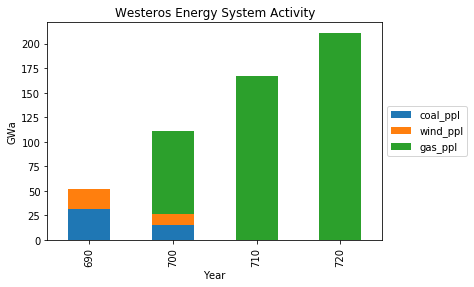

In [76]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

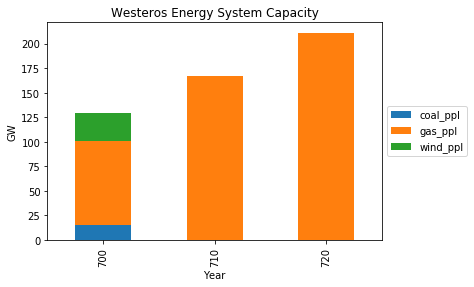

In [77]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

In [78]:
emissions = scen.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,293.881279,0.0
1,Westeros,CO2,all,710,350.000000,0.0
2,Westeros,CO2,all,720,443.333333,0.0


In [79]:
emission_prices = scen.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg


When setting a cumlulative bound, the undiscounted price of emission is the same in different model years (see the marginals of equation EMISSION_CONSTRAINT). However, considering the year-to-year discount factor, we observe an ascending trend in emission prices shown in PRICE_EMISSION above. This means the emission price in later years is higher as the value of money in the future is lower compared to today. 

## Interim Finding: when there is no bound set, natural gas is the only producer in 720.

## 1. Testing bound of 100 Mt

In [80]:
scen_bound_100 = scen.clone(model, 'emission_bound_100','introducing an emission bound of 100 Mt',
                  keep_solution=False)
scen_bound_100.check_out()

In [81]:
scen_bound_100.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=100., unit='MtCO2')

In [82]:
scen_bound_100.commit(comment='introducing an emission bound of 100 Mt')
scen_bound_100.set_as_default()

In [83]:
scen_bound_100.solve()

In [84]:
scen_bound_100.var('OBJ')['lvl']

369858.21875

## Plotting Results

In [85]:
from tools import Plots
p = Plots(scen_bound_100, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

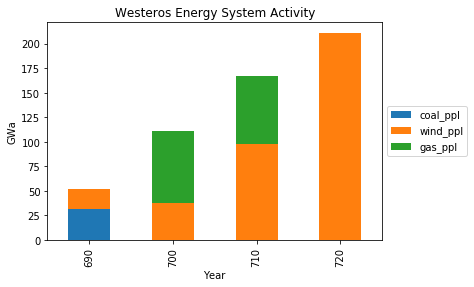

In [86]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

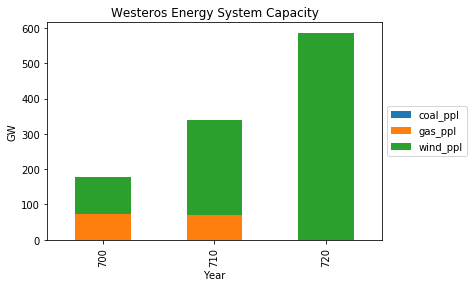

In [87]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

In [88]:
emissions = scen_bound_100.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,154.492588,0.0
1,Westeros,CO2,all,710,145.507412,0.0
2,Westeros,CO2,all,720,0.000000,0.0


In [89]:
emission_prices = scen_bound_100.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,74.199761,0.0
1,Westeros,GHG,all,710,120.863593,0.0
2,Westeros,GHG,all,720,196.874057,0.0


When setting a cumlulative bound, the undiscounted price of emission is the same in different model years (see the marginals of equation EMISSION_CONSTRAINT). However, considering the year-to-year discount factor, we observe an ascending trend in emission prices shown in PRICE_EMISSION above. This means the emission price in later years is higher as the value of money in the future is lower compared to today. 

## 2. Testing bound of 200 Mt

In [90]:
scen_bound_200 = scen.clone(model, 'emission_bound_200','introducing an emission bound of 200 Mt',
                  keep_solution=False)
scen_bound_200.check_out()

In [91]:
scen_bound_200.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=200., unit='MtCO2')

In [92]:
scen_bound_200.commit(comment='introducing an emission bound of 200 Mt')
scen_bound_200.set_as_default()

In [93]:
scen_bound_200.solve()

In [94]:
scen_bound_200.var('OBJ')['lvl']

288437.34375

## Plotting Results

In [95]:
from tools import Plots
p = Plots(scen_bound_200, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

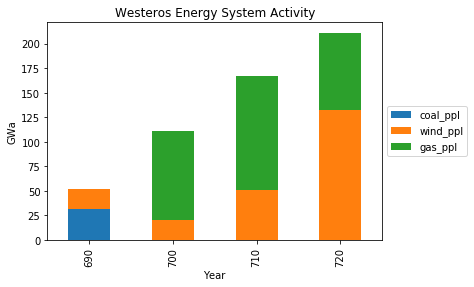

In [96]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

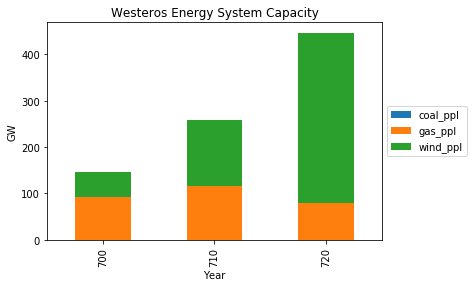

In [97]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

In [98]:
emissions = scen_bound_200.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,191.994641,0.0
1,Westeros,CO2,all,710,242.778078,0.0
2,Westeros,CO2,all,720,165.227281,0.0


In [99]:
emission_prices = scen_bound_200.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,51.789057,0.0
1,Westeros,GHG,all,710,84.358916,0.0
2,Westeros,GHG,all,720,137.411785,0.0


When setting a cumlulative bound, the undiscounted price of emission is the same in different model years (see the marginals of equation EMISSION_CONSTRAINT). However, considering the year-to-year discount factor, we observe an ascending trend in emission prices shown in PRICE_EMISSION above. This means the emission price in later years is higher as the value of money in the future is lower compared to today. 

## 3. Testing bound of 400 Mt

In [100]:
scen_bound_400 = scen.clone(model, 'emission_bound_400','introducing an emission bound of 400 Mt',
                  keep_solution=False)
scen_bound_400.check_out()

In [101]:
scen_bound_400.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=400., unit='MtCO2')

In [102]:
scen_bound_400.commit(comment='introducing an emission bound of 400 Mt')
scen_bound_400.set_as_default()

In [103]:
scen_bound_400.solve()

In [104]:
scen_bound_400.var('OBJ')['lvl']

190966.59375

## Plotting Results

In [105]:
from tools import Plots
p = Plots(scen_bound_400, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

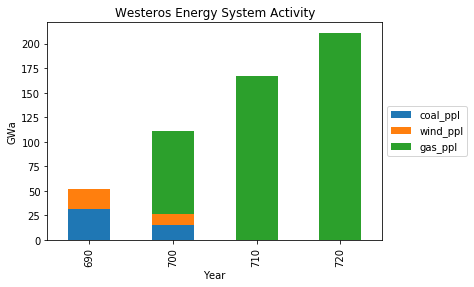

In [106]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

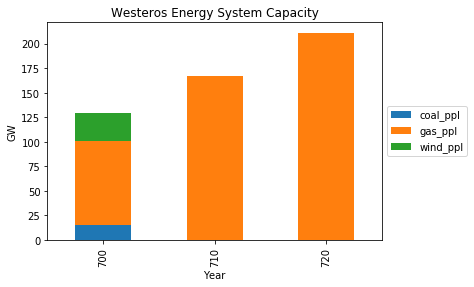

In [107]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

In [108]:
emissions = scen_bound_400.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,293.881279,0.0
1,Westeros,CO2,all,710,350.000000,0.0
2,Westeros,CO2,all,720,443.333333,0.0


In [109]:
emission_prices = scen_bound_400.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg


When setting a cumlulative bound, the undiscounted price of emission is the same in different model years (see the marginals of equation EMISSION_CONSTRAINT). However, considering the year-to-year discount factor, we observe an ascending trend in emission prices shown in PRICE_EMISSION above. This means the emission price in later years is higher as the value of money in the future is lower compared to today. 

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [110]:
mp.close_db()

## Findings: 
At an emission bound of 100 Mt and corresponding CO2 prices of 74, 121, and 197 USD/tCO2, all electricity is produced by wind in 720.

At an emission bound of 200 Mt and corresponding CO2 prices of 52, 84, and 137 USD/tCO2, only wind and gas are generating in the system in the years 700-720.

At an emission bound of 400 Mt, only gas is installed and produces all the electricity after the year 700. 

With these assumptions, there is no sweet spot when gas, coal and wind are used at the same time because the (higher) fuel costs for gas are not included in the model. That makes gas power plants always cheaper than coal power plants. The CO2 price determines just the share of wind and gas in the system, coal is 